In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shap

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from lime.lime_tabular import LimeTabularExplainer

c:\Users\gustavo.o.gois\.conda\envs\tensorflow_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def encode_df_column(df: pd.DataFrame, column: str) -> pd.DataFrame:
    ohe = OneHotEncoder()
    oheFit = ohe.fit_transform(X=df[[column]]).toarray()
    df.drop(labels=[column], axis=1, inplace=True)
    return pd.concat([df, pd.DataFrame(data=oheFit, columns=ohe.categories_[0])], axis=1)

In [3]:
def normalize_df(df: pd.DataFrame) -> pd.DataFrame:
    normalizer = Normalizer().fit(df)
    return pd.DataFrame(data=normalizer.transform(df), columns=df.columns)

In [4]:
airlineSatisfactionDF = pd.read_csv(filepath_or_buffer="train.csv")
airlineSatisfactionDF.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [5]:
testDF = pd.read_csv(filepath_or_buffer="test.csv")
testDF.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [6]:
airlineSatisfactionDF.describe()

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,51951.500000,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,29994.645522,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,0.000000,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25975.750000,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,51951.500000,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,77927.250000,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,103903.000000,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [7]:
airlineSatisfactionDF.drop(labels=["Unnamed: 0", "id"], axis=1, inplace=True)
airlineSatisfactionDF.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [8]:
testDF.drop(labels=["Unnamed: 0", "id"], axis=1, inplace=True)
testDF.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [9]:
airlineSatisfactionDF.columns

Index(['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [10]:
print(airlineSatisfactionDF)

        Gender      Customer Type  Age   Type of Travel     Class  \
0         Male     Loyal Customer   13  Personal Travel  Eco Plus   
1         Male  disloyal Customer   25  Business travel  Business   
2       Female     Loyal Customer   26  Business travel  Business   
3       Female     Loyal Customer   25  Business travel  Business   
4         Male     Loyal Customer   61  Business travel  Business   
...        ...                ...  ...              ...       ...   
103899  Female  disloyal Customer   23  Business travel       Eco   
103900    Male     Loyal Customer   49  Business travel  Business   
103901    Male  disloyal Customer   30  Business travel  Business   
103902  Female  disloyal Customer   22  Business travel       Eco   
103903    Male     Loyal Customer   27  Business travel  Business   

        Flight Distance  Inflight wifi service  \
0                   460                      3   
1                   235                      3   
2                  11

In [11]:
airlineSatisfactionDF = encode_df_column(df=airlineSatisfactionDF, column="Gender")
airlineSatisfactionDF = encode_df_column(df=airlineSatisfactionDF, column="Customer Type")
airlineSatisfactionDF = encode_df_column(df=airlineSatisfactionDF, column="Type of Travel")
airlineSatisfactionDF = encode_df_column(df=airlineSatisfactionDF, column="Class")
airlineSatisfactionDF.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,satisfaction,Female,Male,Loyal Customer,disloyal Customer,Business travel,Personal Travel,Business,Eco,Eco Plus
0,13,460,3,4,3,1,5,3,5,5,...,neutral or dissatisfied,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,25,235,3,2,3,3,1,3,1,1,...,neutral or dissatisfied,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,26,1142,2,2,2,2,5,5,5,5,...,satisfied,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,25,562,2,5,5,5,2,2,2,2,...,neutral or dissatisfied,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,61,214,3,3,3,3,4,5,5,3,...,satisfied,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [12]:
testDF = encode_df_column(df=testDF, column="Gender")
testDF = encode_df_column(df=testDF, column="Customer Type")
testDF = encode_df_column(df=testDF, column="Type of Travel")
testDF = encode_df_column(df=testDF, column="Class")
testDF.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,satisfaction,Female,Male,Loyal Customer,disloyal Customer,Business travel,Personal Travel,Business,Eco,Eco Plus
0,52,160,5,4,3,4,3,4,3,5,...,satisfied,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,36,2863,1,1,3,1,5,4,5,4,...,satisfied,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,20,192,2,0,2,4,2,2,2,2,...,neutral or dissatisfied,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,44,3377,0,0,0,2,3,4,4,1,...,satisfied,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,49,1182,2,3,4,3,4,1,2,2,...,satisfied,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [13]:
airlineSatisfactionDF.isnull().sum()

Age                                    0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
Female                                 0
Male                                   0
Loyal Customer                         0
disloyal Customer                      0
Business travel                        0
Personal Travel 

In [14]:
airlineSatisfactionDF.dropna(inplace=True)

In [15]:
testDF.isnull().sum()

Age                                   0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0
Female                                0
Male                                  0
Loyal Customer                        0
disloyal Customer                     0
Business travel                       0
Personal Travel                       0


In [16]:
testDF.dropna(inplace=True)

In [17]:
X = airlineSatisfactionDF.drop(columns=["satisfaction"])
X

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Arrival Delay in Minutes,Female,Male,Loyal Customer,disloyal Customer,Business travel,Personal Travel,Business,Eco,Eco Plus
0,13,460,3,4,3,1,5,3,5,5,...,18.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,25,235,3,2,3,3,1,3,1,1,...,6.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,26,1142,2,2,2,2,5,5,5,5,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,25,562,2,5,5,5,2,2,2,2,...,9.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,61,214,3,3,3,3,4,5,5,3,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,23,192,2,1,2,3,2,2,2,2,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
103900,49,2347,4,4,4,4,2,4,5,5,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
103901,30,1995,1,1,1,3,4,1,5,4,...,14.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
103902,22,1000,1,1,1,5,1,1,1,1,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [18]:
y = airlineSatisfactionDF["satisfaction"]
y

0         neutral or dissatisfied
1         neutral or dissatisfied
2                       satisfied
3         neutral or dissatisfied
4                       satisfied
                   ...           
103899    neutral or dissatisfied
103900                  satisfied
103901    neutral or dissatisfied
103902    neutral or dissatisfied
103903    neutral or dissatisfied
Name: satisfaction, Length: 103594, dtype: object

In [19]:
model = SVC()
model.fit(X=X, y=y)

SVC()

In [20]:
X_test = testDF.drop(columns=["satisfaction"])
X_test

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Arrival Delay in Minutes,Female,Male,Loyal Customer,disloyal Customer,Business travel,Personal Travel,Business,Eco,Eco Plus
0,52,160,5,4,3,4,3,4,3,5,...,44.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,36,2863,1,1,3,1,5,4,5,4,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,20,192,2,0,2,4,2,2,2,2,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,44,3377,0,0,0,2,3,4,4,1,...,6.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,49,1182,2,3,4,3,4,1,2,2,...,20.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,34,526,3,3,3,1,4,3,4,4,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
25972,23,646,4,4,4,4,4,4,4,4,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
25973,17,828,2,5,1,5,2,1,2,2,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
25974,14,1127,3,3,3,3,4,4,4,4,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [21]:
y_test = testDF["satisfaction"]
y_test

0                      satisfied
1                      satisfied
2        neutral or dissatisfied
3                      satisfied
4                      satisfied
                  ...           
25971    neutral or dissatisfied
25972                  satisfied
25973    neutral or dissatisfied
25974                  satisfied
25975    neutral or dissatisfied
Name: satisfaction, Length: 25893, dtype: object

In [22]:
y_pred = model.predict(X=X_test)

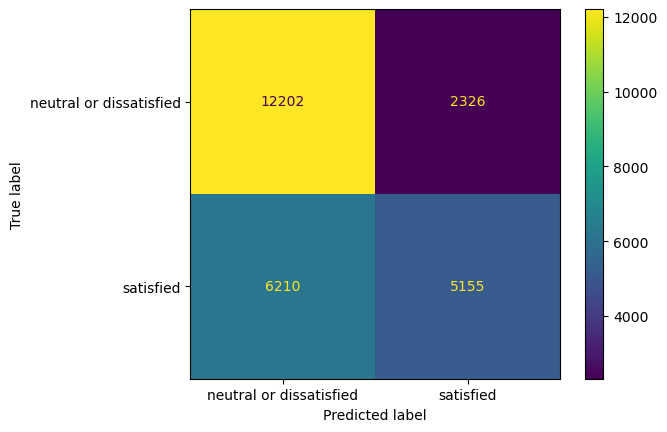

In [23]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [24]:
X_norm = normalize_df(df=X)
X_norm

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Arrival Delay in Minutes,Female,Male,Loyal Customer,disloyal Customer,Business travel,Personal Travel,Business,Eco,Eco Plus
0,0.028171,0.996830,0.006501,0.008668,0.006501,0.002167,0.010835,0.006501,0.010835,0.010835,...,0.039006,0.000000,0.002167,0.002167,0.000000,0.000000,0.002167,0.000000,0.000000,0.002167
1,0.105657,0.993172,0.012679,0.008453,0.012679,0.012679,0.004226,0.012679,0.004226,0.004226,...,0.025358,0.000000,0.004226,0.000000,0.004226,0.004226,0.000000,0.004226,0.000000,0.000000
2,0.022759,0.999657,0.001751,0.001751,0.001751,0.001751,0.004377,0.004377,0.004377,0.004377,...,0.000000,0.000875,0.000000,0.000875,0.000000,0.000875,0.000000,0.000875,0.000000,0.000000
3,0.044415,0.998444,0.003553,0.008883,0.008883,0.008883,0.003553,0.003553,0.003553,0.003553,...,0.015989,0.001777,0.000000,0.001777,0.000000,0.001777,0.000000,0.001777,0.000000,0.000000
4,0.273622,0.959921,0.013457,0.013457,0.013457,0.013457,0.017942,0.022428,0.022428,0.013457,...,0.000000,0.000000,0.004486,0.004486,0.000000,0.004486,0.000000,0.004486,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103589,0.118798,0.991709,0.010330,0.005165,0.010330,0.015495,0.010330,0.010330,0.010330,0.010330,...,0.000000,0.005165,0.000000,0.000000,0.005165,0.005165,0.000000,0.000000,0.005165,0.000000
103590,0.020873,0.999757,0.001704,0.001704,0.001704,0.001704,0.000852,0.001704,0.002130,0.002130,...,0.000000,0.000000,0.000426,0.000426,0.000000,0.000426,0.000000,0.000426,0.000000,0.000000
103591,0.015035,0.999835,0.000501,0.000501,0.000501,0.001504,0.002005,0.000501,0.002506,0.002005,...,0.007016,0.000000,0.000501,0.000000,0.000501,0.000501,0.000000,0.000501,0.000000,0.000000
103592,0.021993,0.999698,0.001000,0.001000,0.001000,0.004998,0.001000,0.001000,0.001000,0.001000,...,0.000000,0.001000,0.000000,0.000000,0.001000,0.001000,0.000000,0.000000,0.001000,0.000000


In [25]:
X_test_norm = normalize_df(df=X_test)
X_test_norm

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Arrival Delay in Minutes,Female,Male,Loyal Customer,disloyal Customer,Business travel,Personal Travel,Business,Eco,Eco Plus
0,0.286259,0.880798,0.027525,0.022020,0.016515,0.022020,0.016515,0.022020,0.016515,0.027525,...,0.242219,0.005505,0.000000,0.005505,0.000000,0.005505,0.000000,0.000000,0.005505,0.0
1,0.012573,0.999909,0.000349,0.000349,0.001048,0.000349,0.001746,0.001397,0.001746,0.001397,...,0.000000,0.000349,0.000000,0.000349,0.000000,0.000349,0.000000,0.000349,0.000000,0.0
2,0.103492,0.993526,0.010349,0.000000,0.010349,0.020698,0.010349,0.010349,0.010349,0.010349,...,0.000000,0.000000,0.005175,0.000000,0.005175,0.005175,0.000000,0.000000,0.005175,0.0
3,0.013028,0.999910,0.000000,0.000000,0.000000,0.000592,0.000888,0.001184,0.001184,0.000296,...,0.001777,0.000000,0.000296,0.000296,0.000000,0.000296,0.000000,0.000296,0.000000,0.0
4,0.041412,0.998958,0.001690,0.002535,0.003381,0.002535,0.003381,0.000845,0.001690,0.001690,...,0.016903,0.000845,0.000000,0.000845,0.000000,0.000845,0.000000,0.000000,0.000845,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25888,0.064484,0.997603,0.005690,0.005690,0.005690,0.001897,0.007586,0.005690,0.007586,0.007586,...,0.000000,0.000000,0.001897,0.000000,0.001897,0.001897,0.000000,0.001897,0.000000,0.0
25889,0.035570,0.999051,0.006186,0.006186,0.006186,0.006186,0.006186,0.006186,0.006186,0.006186,...,0.000000,0.000000,0.001547,0.001547,0.000000,0.001547,0.000000,0.001547,0.000000,0.0
25890,0.020525,0.999674,0.002415,0.006037,0.001207,0.006037,0.002415,0.001207,0.002415,0.002415,...,0.000000,0.001207,0.000000,0.001207,0.000000,0.000000,0.001207,0.000000,0.001207,0.0
25891,0.012420,0.999845,0.002662,0.002662,0.002662,0.002662,0.003549,0.003549,0.003549,0.003549,...,0.000000,0.000000,0.000887,0.000887,0.000000,0.000887,0.000000,0.000887,0.000000,0.0


In [26]:
model_norm = SVC()
model_norm.fit(X=X_norm, y=y)

SVC()

In [27]:
y_pred_norm = model_norm.predict(X=X_test_norm)

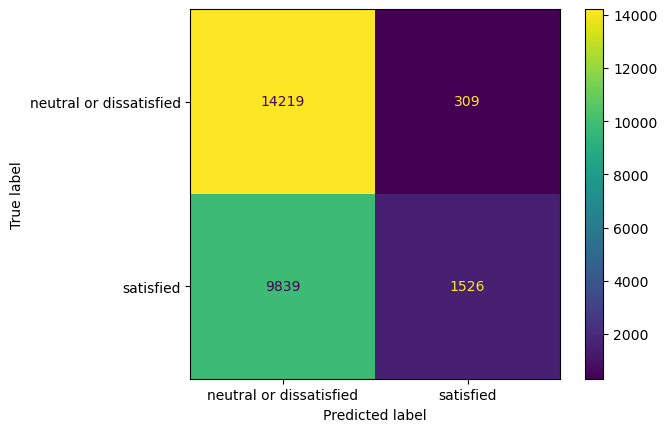

In [28]:
cm_norm = confusion_matrix(y_true=y_test, y_pred=y_pred_norm, labels=model_norm.classes_)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=model_norm.classes_)
disp_norm.plot()
plt.show()

In [29]:
print(accuracy_score(y_true=y_test, y_pred=y_pred), accuracy_score(y_true=y_test, y_pred=y_pred_norm))

In [30]:
treeModel = DecisionTreeClassifier()
treeModel.fit(X=X, y=y)

treeModelNorm = DecisionTreeClassifier()
treeModelNorm.fit(X=X_test_norm, y=y_test)

DecisionTreeClassifier()

In [52]:
treeModelEntropy = DecisionTreeClassifier(criterion="entropy")
y = [1 if x=="satisfied" else 0 for x in y]
y_test = [1 if x=="satisfied" else 0 for x in y_test]
treeModelEntropy.fit(X=X, y=y)

DecisionTreeClassifier(criterion='entropy')

In [53]:
y_pred_tree = treeModel.predict(X=X_test)

In [54]:
y_pred_entropy_tree = treeModelEntropy.predict(X=X_test)

In [55]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_tree, labels=treeModel.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=treeModel.classes_)
disp.plot()
plt.show()

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=[0] and y_pred=['neutral or dissatisfied' 'satisfied']. Make sure that the predictions provided by the classifier coincides with the true labels.

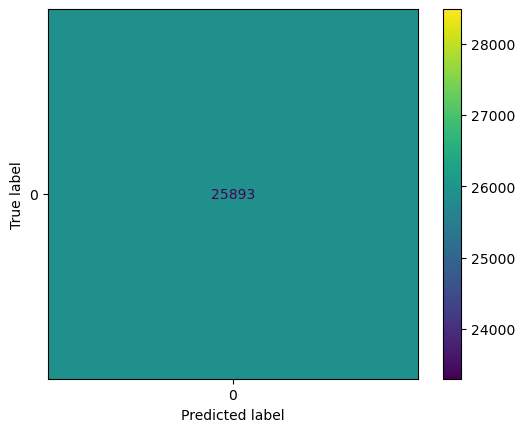

In [56]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_entropy_tree, labels=treeModelEntropy.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=treeModelEntropy.classes_)
disp.plot()
plt.show()

In [57]:
accuracy_score(y_true=y_test, y_pred=y_pred_tree)

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=[0] and y_pred=['neutral or dissatisfied' 'satisfied']. Make sure that the predictions provided by the classifier coincides with the true labels.

In [58]:
accuracy_score(y_true=y_test, y_pred=y_pred_entropy_tree)

1.0

In [59]:
y_norm_pred_tree = treeModelNorm.predict(X=X_test_norm)

In [60]:
cm = confusion_matrix(y_true=y_test, y_pred=y_norm_pred_tree, labels=treeModelNorm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=treeModelNorm.classes_)
disp.plot()
plt.show()

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=[0] and y_pred=['neutral or dissatisfied' 'satisfied']. Make sure that the predictions provided by the classifier coincides with the true labels.

In [61]:
# Overfitted
accuracy_score(y_true=y_test, y_pred=y_norm_pred_tree)

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=[0] and y_pred=['neutral or dissatisfied' 'satisfied']. Make sure that the predictions provided by the classifier coincides with the true labels.

In [62]:
parameters = {"kernel":["linear", "poly", "rbf", "sigmoid", "precomputed"], "gamma": ["scale", "auto"]}

In [ ]:
gridSearchSVC = GridSearchCV(model, parameters)
gridSearchSVC.fit(X=X, y=y)

In [63]:
exp = shap.Explainer(treeModelEntropy.predict, X_test)

In [64]:
shap_values = exp(X_test)

Permutation explainer: 25894it [10:32, 40.18it/s]                           
